# Personal Information Factor (PIF) - Computing the cell information gain (CIG)

The PIF tries to answer the question: 

_"Knowing everything about a person but one feature's value, what's the information one would gain learning that value?"_

The information gain is a measure of how unexpected the value is. The higher the information gain, the more unusual
the value is, given the values for all remaining features.

We compute the information gain as the KL-divergence between the distribution of values of the whole dataset (the
features' priors) and the distribution of a feature's values given all remaining features' values (posterior).

In [12]:
import collections
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

import piflib

from tutorial_helpers import horizontal_bar_plot

## Example dataset
We define a toy dataset to explain the process. Feel free to modify the dataset and examine the behaviour of the
corresponding CIG values.

In [13]:
data = {'gender': (['male'] * 6)+['female'], 
        'name': ['Anton', 'Bill', 'Charlie', 'Don', 'Emil', 'Emil', 'Charlie'], 
        'eye_color': ['blue', 'green', 'green', 'green', 'blue', 'green', 'green']}
df = pd.DataFrame(data)
df

,gender,name,eye_color
0,male,Anton,blue
1,male,Bill,green
2,male,Charlie,green
3,male,Don,green
4,male,Emil,blue
5,male,Emil,green
6,female,Charlie,green


## The features' priors
Looking at the dataset as a whole, what is the distribution of the values of each feature.
Not having any information about a person, this is what we expect him/her to look like.

In [14]:
from piflib.data_util import calculate_distribution

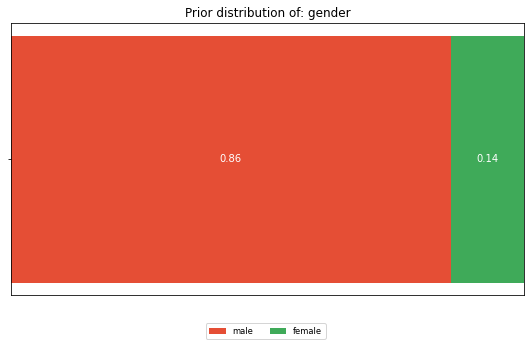

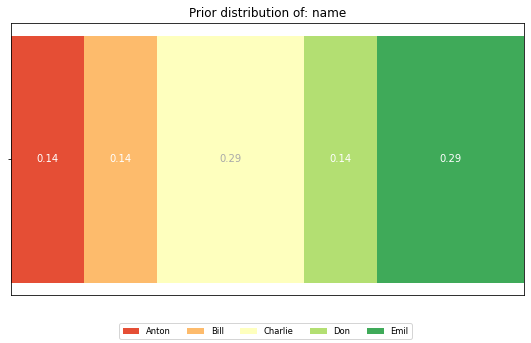

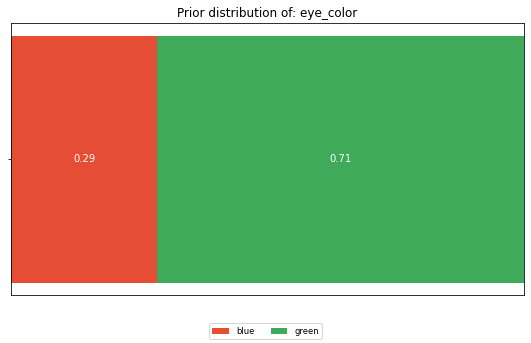

In [15]:
for feature in df.columns:
    dist = calculate_distribution(df[feature])
    horizontal_bar_plot({'': list(dist.values())}, dist.keys())
    plt.title(f'Prior distribution of: {feature}')

## The posterior distributions

To compute a feature's posterior distribution, we have to take its context into account. 
For example, in the given dataset, there are two posterior distributions for the feature 'name'. One where the pair gender and eye color is "male, green" and one for "male, blue".

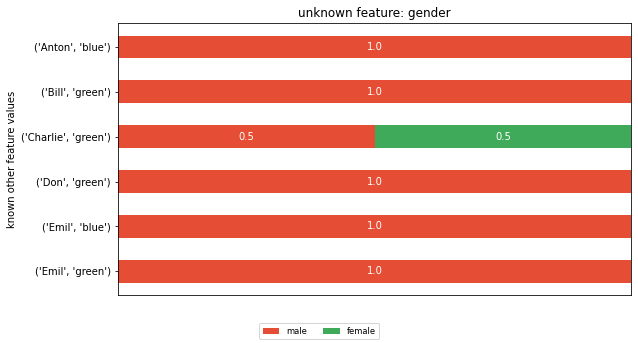

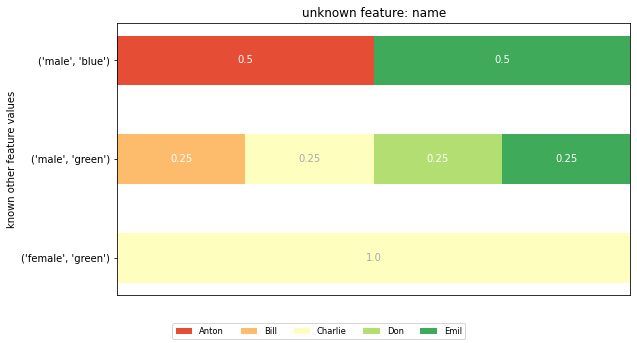

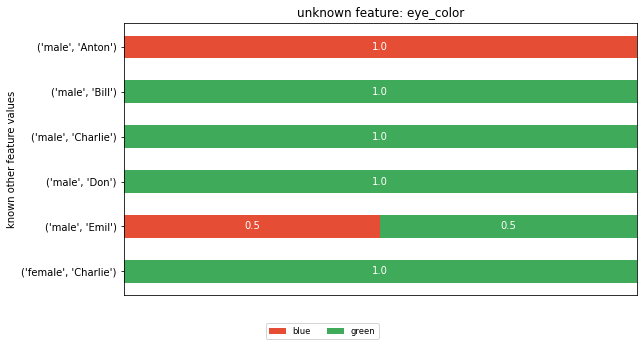

In [16]:
for feature in df.columns:
    known_features = tuple(col_name for col_name in df.columns if col_name != feature)
    bucket = collections.defaultdict(list)
    bucket_map = []
    for idx, row in df.iterrows():
        key = tuple(row[known_feature] for known_feature in known_features)
        bucket[key].append(row[feature])
        bucket_map.append(key)

    bucket_distributions = {key: calculate_distribution(el_bucket) for key, el_bucket in bucket.items()}
    feature_vals = df[feature].unique()
    dists = {}
    for key, distribution in bucket_distributions.items():
        dists[str(key)] = [distribution.get(feature_val, 0) for feature_val in feature_vals]

    horizontal_bar_plot(dists, feature_vals)
    plt.title(f'unknown feature: {feature}')
    plt.ylabel('known other feature values')
    plt.show()

## The CIG values:
Given a features' prior and posterior distributions, one can compute the KL-divergence between the two for each cell in the dataset. This will form the CIG value.

In [17]:
piflib.compute_cigs(df).round(2)

,gender,name,eye_color
0,0.22,1.31,1.81
1,0.22,0.31,0.49
2,0.51,0.31,0.49
3,0.22,0.31,0.49
4,0.22,1.31,0.15
5,0.22,0.31,0.15
6,0.51,1.81,0.49


Looking at both CIG values that correspond to a 'blue' eye color, we can see that they got assigned very different CIG
values.
In row 0 the CIG is 1.81, whereas in row 4 the CIG is 0.15.
To understand the difference, you have to appreciate the different cohorts that fed into the CIG computation.
The cohort (gender=male, name=Anton) that forms the posterior in row 0 is of size 1,
whereas the cohort for row 4 (gender=male, name=Emil) is of size 2. The eye_color distribution of the second cohort
is similar to the prior, thus the CIG value is low.

Or looking at it from an attacker perspective, if I know that the target's name is Anton with a male gender, I would
learn his eye color. In contrast, if the target's name is Emil with a male gender, the attacker is left with a
50/50 chance for blue and green. This is close to his prior believe of 29/71.

I also want to draw attention to line 1. Why is the CIG different, given that here too, the cohort size is 1? This
is explained by the prior believe. The attacker believes that 71% of the people in the dataset have green eyes.
Thus, learning that Bill has green eyes is less of a surprise than learning that Anton has blue eyes.

## Going bigger - hackathon dataset

In [18]:
hack_features = ['gender', 'AGE', 'POSTCODE', 'blood_group', 'eye_color', 'job']
hack_data = pd.read_csv('data/hackathon.csv')[hack_features]
hack_data = hack_data.fillna('Unemployed')
hack_data.head()

,gender,AGE,POSTCODE,blood_group,eye_color,job
0,F,99,2649,B-,Brown,"Psychologist, counselling"
1,M,108,1780,A-,Hazel,Personnel officer
2,M,59,2940,B+,Hazel,Tourism officer
3,M,58,2945,B+,Blue,Make
4,M,30,2729,AB-,Brown,Forest/woodland manager


We now compute the CIG values and display them as a heatmap, with colors ranging from green for 'save' values to red for the most at risk values.

<AxesSubplot:>

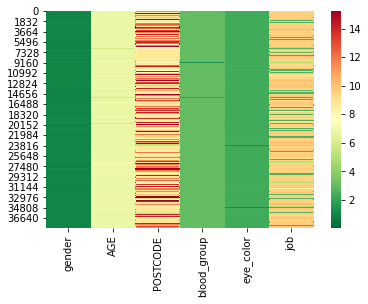

In [19]:
hack_cig = piflib.compute_cigs(hack_data)
color_map = matplotlib.colors.ListedColormap(
        sns.color_palette("RdYlGn", 256).as_hex()[::-1])
sns.heatmap(hack_cig, cmap=color_map)

Looking at the distribution of CIG values, we can see that the changes are quite substantial.

In [20]:
hack_cig.describe()

,gender,AGE,POSTCODE,blood_group,eye_color,job
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.996891,6.827838,10.058929,2.987481,2.313486,8.306507
std,0.068946,0.223181,2.583055,0.121209,0.093568,2.667701
min,0.000887,4.029292,4.754066,0.667983,0.730567,2.606579
25%,0.950303,6.788203,8.572935,2.979960,2.311166,9.300409
50%,0.950303,6.860459,8.821755,2.996329,2.324443,9.530706
75%,1.051470,6.904717,11.909218,3.011675,2.330845,9.707584
max,1.051470,11.909218,15.231146,3.023827,2.332356,10.707584


Let's try to reduce the CIG values by removing the features 'job' and 'POSTCODE'. Removing features will lead to larger
cohort sizes for the posterior distributions. Alternatively, you could also 

<AxesSubplot:>

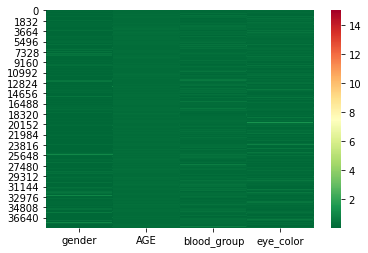

In [21]:
cols = ['gender', 'AGE', 'blood_group', 'eye_color']
sub_hack_cig = piflib.compute_cigs(hack_data[cols])
sns.heatmap(sub_hack_cig, cmap=color_map, vmax=15)

In [22]:
sub_hack_cig.describe()

,gender,AGE,blood_group,eye_color
count,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.094231,0.181759,0.164312,0.147753
std,0.157085,0.028178,0.106338,0.122034
min,0.000114,0.129416,0.015208,0.000030
25%,0.008432,0.161430,0.094626,0.063763
50%,0.040053,0.180967,0.142773,0.121803
75%,0.099452,0.197749,0.211684,0.190624
max,1.051470,0.253509,3.023827,2.332356


This already looks a lot better. The mean CIG values are a lot lower now. However, there are still some rows in the
dataset with high CIG values. These rows still stand out and thus have a higher risk of re-identification.
